# Binary classification based on 3 layers neural network

#### First layer

$Z^{[1]} = W^{[1]} X + b^{[1]}$ : $X$ denotes the input data
$A^{[1]} = g^{[1]}(Z^{[1]})$ : $g^{[1]}$ is the activation function at the first layer

#### Second layer

$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$

$A^{[2]} = g^{[2]}(Z^{[2]})$ : $g^{[2]}$ is the activation function at the second layer

#### Third layer

$Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}$

$A^{[3]} = g^{[3]}(Z^{[3]})$ : $g^{[3]}$ is the activation function at the third (output) layer


## import library & plot functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision

In [2]:
def output_plot(g1, g2, title, color, label, legend):
    plt.title(title)
    plt.plot(np.arange(1, len(g1) + 1), g1, color=color[0], alpha=0.5, label=label[0])
    plt.plot(np.arange(1, len(g2) + 1), g2, color=color[1], alpha=0.5, label=label[1])
    plt.legend(loc=legend)
    plt.show()


def output_frame_plot(tloss, vloss, tacc, vacc, b_vloss, b_vacc, title):
    print(" << %s >>" % title)
    print("------------------------------------------------------")
    print("                |   %10s    |    %10s     |" % ('loss', 'accuracy'))
    print("------------------------------------------------------")
    print("training        |   %.10f   |    %.10f    |" % (tloss, tacc))
    print("------------------------------------------------------")
    print("validation      |   %.10f   |    %.10f    |" % (vloss, vacc))
    print("------------------------------------------------------")
    print("best validation |   %.10f   |    %.10f    |" % (b_vloss, b_vacc))
    print("------------------------------------------------------")

## Declare the constants

In [3]:
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNEL = 1
DIMENSION = IMAGE_CHANNEL * IMAGE_HEIGHT * IMAGE_WIDTH

## Load train & validation datasets (preprocess)

* batch size = 3
* number of workers = 1 (main process + worker1)
* number of epoch = 1

In [4]:
def pre_process(batch_size=3, num_workers=1):
    transform = transforms.Compose([  # transforms.Resize((256,256)),
        transforms.Grayscale(),
        # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
        transforms.ToTensor(), ])

    # train_data_path = 'relative path of training data set'
    train_data_path = './horse-or-human/train'
    trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    # if shuffle=True, the data reshuffled at every epoch
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    validation_data_path = './horse-or-human/validation'
    valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    train_data = np.empty((DIMENSION, 0))
    validation_data = np.empty((DIMENSION, 0))

    train_label = np.array([])
    validation_label = np.array([])

    for i, data in enumerate(trainloader):
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]

        # [batch_size, 1, height, width] => [ width * height * channel, batch_size ]
        x = np.array(inputs).transpose((2, 3, 0, 1)).reshape((DIMENSION, len(labels)))
        train_data = np.concatenate((train_data, x), axis=1)
        train_label = np.concatenate((train_label, np.array(labels)))

    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # [batch_size, 1, height, width] => [ width * height * channel, batch_size ]
        x = np.array(inputs).transpose((2, 3, 0, 1)).reshape((DIMENSION, len(labels)))
        validation_data = np.concatenate((validation_data, x), axis=1)
        validation_label = np.concatenate((validation_label, np.array(labels)))

    return train_data, validation_data, train_label, validation_label


t_data, v_data, t_label, v_label = pre_process(batch_size=3, num_workers=1)

## Implements of 3 layers neural network

### Architecture

#### Parameters
* $g^{[1]}, g^{[2]}$ are Leaky ReLU ($\alpha=0.001)$ and $g^{[3]}$ is Sigmoid
* learning rate = $0.0005$
* tolerance = $10^{-6}$
* initialization : $Var(w_i) = \frac{2}{n_{in}}$

#### Input layer
* num of features = $10000$ (100 * 100 image)
* num of samples = $1027$ (number of training image samples)

#### hidden layer 1
* num of features (nodes) = $50$
* activation function = Leaky ReLU

#### hidden layer 2
* num of features (nodes) = $150$
* activation function = Leaky ReLU

#### output layer
* num of features (nodes) = $1$
* activation function = Sigmoid

---

### Implemenations

In [5]:
# binary classifier
def binary_classify(train_data, validation_data,
                    train_label, validation_label,
                    gn_act, gn_d_act, init, learning_rate=0.0002):

    num_of_layers = 3
    n1, n2 = 50, 150
    learning_rate = learning_rate
    epsilon = 10e-6

    # INITIALIZE u v z
    u, v, w = init(DIMENSION, n1, n2)

    # INITIALIZE bias
    b1 = np.zeros((n1, 1))
    b2 = np.random.randn(n2, 1)
    b3 = np.zeros((1, 1))

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # def safe_ln(x, minval=10e-20):
    #     return np.log(x.clip(min=minval))

    def cross_entropy(prob, ans):
        return -(np.nan_to_num(ans * np.log(prob)) + np.nan_to_num((1 - ans) * np.log(1-prob)))
        # return -(ans * safe_ln(prob) + (1 - ans) * safe_ln(1-prob))

    def loss(prob, ans):
        return (1 / len(ans)) * np.nan_to_num(np.sum(cross_entropy(prob, ans)))

    def accuracy(prob, ans):
        arr = np.array(list(map(lambda x: 1 if x > 0.5 else 0, prob.flatten())))
        arr = list(filter(lambda x: x == 0, arr - ans))
        return len(arr) / len(ans)

    def iterate():
        p_train_loss = 0
        nonlocal u, v, w, b1, b2, b3
        nonlocal train_losses, test_losses, train_accuracies, test_accuracies

        while True:

            # forward propagation #
            act = gn_act()
            next(act)
            z1 = np.dot(u.T, train_data) + b1
            a1 = act.send(z1)

            z2 = np.dot(v.T, a1) + b2
            a2 = act.send(z2)

            z3 = np.dot(w.T, a2) + b3
            a3 = act.send(z3)

            act = gn_act()
            next(act)
            vz = np.dot(u.T, validation_data) + b1
            vz = np.dot(v.T, act.send(vz)) + b2
            vz = np.dot(w.T, act.send(vz)) + b3
            ####

            # back propagation #
            d_act = gn_d_act()
            next(d_act)
            cw = (a3 - train_label)
            dw = np.dot(cw, a2.T) / z3.shape[1]

            cv = np.dot(w, cw) * d_act.send(z2)
            dv = np.dot(cv, a1.T) / z3.shape[1]

            cu = np.dot(v, cv) * d_act.send(z1)
            du = np.dot(cu, train_data.T) / z3.shape[1]

            b3 = b3 - (learning_rate * (np.sum(cw, axis=1, keepdims=True) / z3.shape[1]))
            b2 = b2 - (learning_rate * (np.sum(cv, axis=1, keepdims=True) / z3.shape[1]))
            b1 = b1 - (learning_rate * (np.sum(cu, axis=1, keepdims=True) / z3.shape[1]))

            # gradient descent #
            w = w - (learning_rate * dw).T
            v = v - (learning_rate * dv).T
            u = u - (learning_rate * du).T
            ####

            # get losses
            t_hat, v_hat = a3, act.send(vz)

            n_train_loss = loss(t_hat, train_label)
            n_test_loss = loss(v_hat, validation_label)

            # get accuracies
            n_train_acc = accuracy(t_hat, train_label)
            n_test_acc = accuracy(v_hat, validation_label)

            train_losses.append(n_train_loss)
            test_losses.append(n_test_loss)
            train_accuracies.append(n_train_acc)
            test_accuracies.append(n_test_acc)

            if abs(p_train_loss - n_train_loss) < epsilon:
                break
            else:
#                 print('t loss: %s, v loss: %s' % (n_train_loss, n_test_loss))
                p_train_loss = n_train_loss
                continue

    iterate()

    return train_losses, test_losses, train_accuracies, test_accuracies

---

In [6]:
def learn(case, title):

    leaky_alpha = 0.001

    t_data, v_data, t_label, v_label = pre_process(batch_size=3, num_workers=1)
    train_loss, test_loss, train_acc, test_acc = [], [], [], []

    # initialization functions
    def he_initialize(n0, n1, n2):
        u = np.random.randn(n0, n1) / np.sqrt(n0/2)
        v = np.random.randn(n1, n2) / np.sqrt(n1/2)
        w = np.random.randn(n2, 1) / np.sqrt(n2/2)
        return u, v, w

    def xaiver_initialize(n0, n1, n2):
        u = np.random.randn(n0, n1) * np.sqrt(1 / n0)
        v = np.random.randn(n1, n2) * np.sqrt(1 / n1)
        w = np.random.randn(n2, 1) * np.sqrt(1 / n2)
        return u, v, w

    def gen_xaiver_initialize(n0, n1, n2):
        u = np.random.randn(n0, n1) * np.sqrt(1 / (n0 + n1))
        v = np.random.randn(n1, n2) * np.sqrt(1 / (n1 + n2))
        w = np.random.randn(n2, 1) * np.sqrt(1 / (n2 + 1))
        return u, v, w

    # activation functions
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def d_sigmoid(z):
        return sigmoid(z) * (1 - sigmoid(z))

    def tanh(z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

    def d_tanh(z):
        return 1 - (tanh(z) ** 2)

    def relu(z):
        return np.maximum(0, z)

    def d_relu(z):
        return np.where(z <= 0, 0, 1)

    def leaky_relu(z):
        return np.maximum(leaky_alpha * z, z)

    def d_leaky_relu(z):
        return np.where(z <= 0, leaky_alpha, 1)

    # case-studies
    # sigmoid
    def case1(learning_rate):
        def act():
            z = yield
            z = yield sigmoid(z)
            z = yield sigmoid(z)
            z = yield sigmoid(z)

        def d_act():
            z = yield
            z = yield d_sigmoid(z)
            z = yield d_sigmoid(z)

        classify(
            gn=act,
            dgn=d_act,
            learning_rate=learning_rate,
            init=gen_xaiver_initialize
        )
        plot()

    # tanh
    def case2(learning_rate):
        def act():
            z = yield
            z = yield tanh(z)
            z = yield tanh(z)
            z = yield sigmoid(z)

        def d_act():
            z = yield
            z = yield d_tanh(z)
            z = yield d_tanh(z)

        classify(
            gn=act,
            dgn=d_act,
            learning_rate=learning_rate,
            init=xaiver_initialize
        )
        plot()

    # relu
    def case3(learning_rate):
        def act():
            z = yield
            z = yield relu(z)
            z = yield relu(z)
            z = yield sigmoid(z)

        def d_act():
            z = yield
            z = yield d_relu(z)
            z = yield d_relu(z)

        classify(
            gn=act,
            dgn=d_act,
            learning_rate=learning_rate,
            init=he_initialize
        )
        plot()

    # leaky relu
    def case4(learning_rate):
        def act():
            z = yield
            z = yield leaky_relu(z)
            z = yield leaky_relu(z)
            z = yield sigmoid(z)

        def d_act():
            z = yield
            z = yield d_leaky_relu(z)
            z = yield d_leaky_relu(z)

        classify(
            gn=act,
            dgn=d_act,
            learning_rate=learning_rate,
            init=he_initialize
        )
        plot()

    def classify(gn, dgn, learning_rate, init):
        nonlocal train_loss, test_loss, train_acc, test_acc

        train_loss, test_loss, train_acc, test_acc = binary_classify(
            t_data, v_data,
            t_label, v_label,
            gn, dgn,
            learning_rate=learning_rate,
            init=init
        )

    def plot():
        output_plot(train_loss, test_loss,
                    title="Loss (ENERGY) :: " + title, color=('blue', 'red'),
                    label=('train loss', 'validation loss'), legend='upper right')

        output_plot(train_acc, test_acc,
                    title="Accuracy :: " + title, color=('blue', 'red'),
                    label=('train accuracy', 'validation accuracy'), legend='lower right')

        output_frame_plot(
            train_loss[-1], test_loss[-1],
            train_acc[-1], test_acc[-1],
            test_loss[np.argmax(test_acc)], max(test_acc),
            title=title
        )

    if case == 1:
        case1(learning_rate=0.015)
    elif case == 2:
        case2(learning_rate=0.0015)
    elif case == 3:
        case3(learning_rate=0.0015)
    elif case == 4:
        case4(learning_rate=0.0005)

---

### Plot

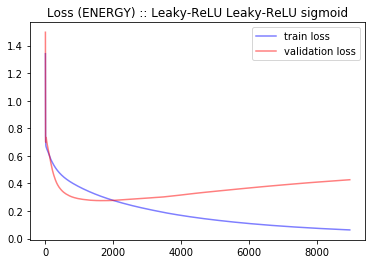

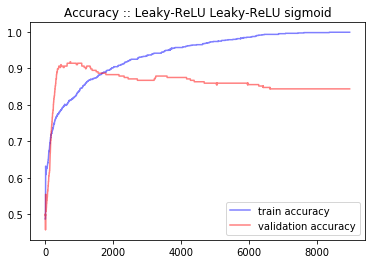

 << Leaky-ReLU Leaky-ReLU sigmoid >>
------------------------------------------------------
                |         loss    |      accuracy     |
------------------------------------------------------
training        |   0.0625090566   |    0.9990262902    |
------------------------------------------------------
validation      |   0.4266293346   |    0.8437500000    |
------------------------------------------------------
best validation |   0.3073591658   |    0.9179687500    |
------------------------------------------------------


In [7]:
learn(case=4, title="Leaky-ReLU Leaky-ReLU sigmoid")